In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

In [5]:
class_names=['Gun','Knife','Money','Phone']
class_names_label= {class_name:i for i,class_name in enumerate(class_names)}

nb_classes=len(class_names)

print(class_names_label)

IMAGE_SIZE=(150,150)

{'Gun': 0, 'Knife': 1, 'Money': 2, 'Phone': 3}


In [6]:
def load_data():
    DIRECTORY=r"C:\Misc"
    CATEGORY= ["Seg_train","Seg_test"]
    
    output=[]
    
    for category in CATEGORY:
        path=os.path.join(DIRECTORY, category)
        images=[]
        labels=[]
        
        print("Loading {}".format(category))
        
        for folder in os.listdir(path):
            label=class_names_label[folder]
            
            for file in os.listdir(os.path.join(path,folder)):
                
                img_path=os.path.join(os.path.join(path,folder),file)
                
                image=cv2.imread(img_path)
                image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image=cv2.resize(image,IMAGE_SIZE)
                
                images.append(image)
                labels.append(label)
                
                
        images=np.array(images,dtype='float32')
        labels=np.array(labels,dtype='int32')
        
        output.append((images,labels))
        
    return output

In [7]:
(train_images,train_labels),(test_images,test_labels)=load_data()

Loading Seg_train
Loading Seg_test


In [8]:
train_images,train_labels=shuffle(train_images,train_labels,random_state=25)

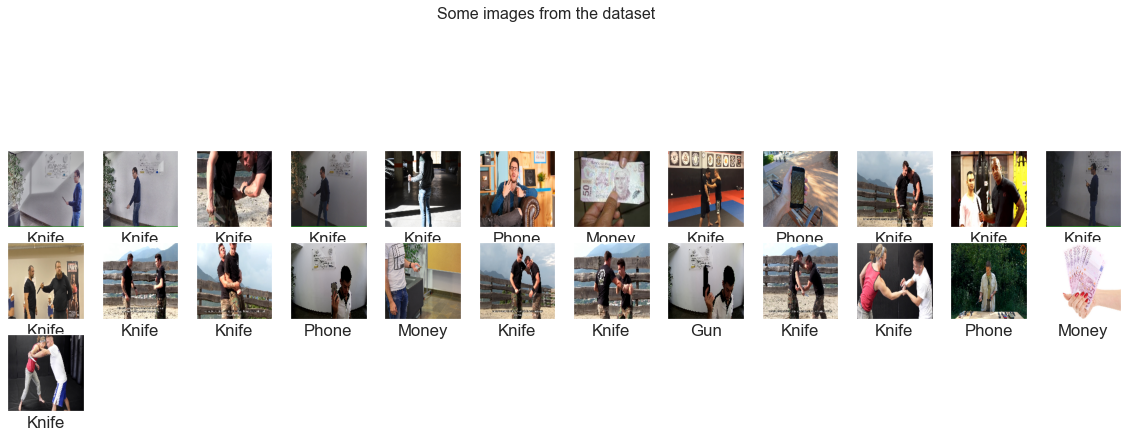

In [9]:
def display_examples(class_names,images,labels):
    
    figsize=(20,20)
    fig= plt.figure(figsize=figsize)
    fig.suptitle("Some images from the dataset",fontsize=16)
    
    for i in range(25):
        plt.subplot(12,12,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        plt.imshow(images[i].astype(np.uint8))
        plt.xlabel(class_names[labels[i]])
        
    plt.show()
display_examples(class_names,train_images,train_labels)

In [10]:
model=tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation=tf.nn.relu),
    tf.keras.layers.Dense(6,activation=tf.nn.softmax)
    
])

In [11]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [12]:
history=model.fit(train_images,train_labels,batch_size=128,epochs=4,validation_split=0.2)

Train on 963 samples, validate on 241 samples
Epoch 1/4
963/963 [==============================] - ETA: 0s - loss: 270.0322 - accuracy: 0.3655

C:\Users\sihus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


963/963 [==============================] - 5s 5ms/sample - loss: 270.0322 - accuracy: 0.3655 - val_loss: 61.7782 - val_accuracy: 0.6390
Epoch 2/4
963/963 [==============================] - 5s 5ms/sample - loss: 21.8874 - accuracy: 0.6698 - val_loss: 4.2538 - val_accuracy: 0.6556
Epoch 3/4
963/963 [==============================] - 5s 5ms/sample - loss: 0.7981 - accuracy: 0.8453 - val_loss: 1.6216 - val_accuracy: 0.7552
Epoch 4/4
963/963 [==============================] - 5s 5ms/sample - loss: 0.2619 - accuracy: 0.9190 - val_loss: 1.4198 - val_accuracy: 0.7303


In [13]:
def plot_accuracy_loss(history):
    
    
    fig=plt.figure(figsize=(10,5))
    
    
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--',label='acc')
    plt.plot(history.history['val_accuracy'],'ro--',label='val_acc')
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    
    
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--',label='loss')
    plt.plot(history.history['val_loss'],'ro--',label='val_loss')
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.show()

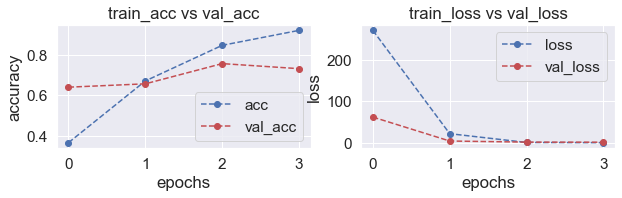

In [14]:
plot_accuracy_loss(history)

In [15]:
test_loss=model.evaluate(test_images,test_labels)

In [16]:
predictions=model.predict(test_images)
pred_labels=np.argmax(predictions,axis=1)
print(classification_report(test_labels,pred_labels))

C:\Users\sihus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


              precision    recall  f1-score   support

           0       0.60      0.73      0.66        44
           1       0.70      0.99      0.82       213
           2       1.00      0.60      0.75       234
           3       0.88      0.81      0.84        43

    accuracy                           0.78       534
   macro avg       0.80      0.78      0.77       534
weighted avg       0.84      0.78      0.78       534



In [17]:

import tensorflow as tf
from art.estimators.classification import KerasClassifier
tf.compat.v1.disable_eager_execution()
from art.attacks.evasion import FastGradientMethod

# EVASION ATTACK

In [18]:
classifier = KerasClassifier(
    model=model,              # indicates our model
    clip_values=(0, 1)    # minimum and maximum values allowed for features
    )

In [19]:
attack_fgsm = FastGradientMethod(
    estimator=classifier,            # attack will apply to our classifier
    eps=0.3                          # defines the strength of the attack
    )

In [20]:
test_images_adv = attack_fgsm.generate(x=test_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


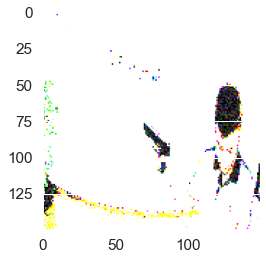

In [21]:
plt.imshow(X=test_images_adv[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

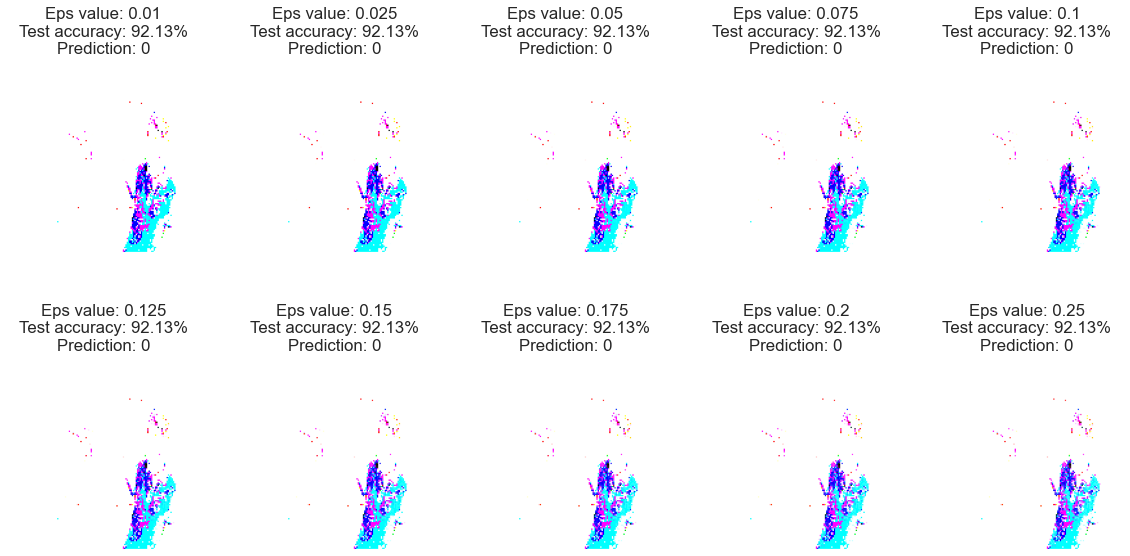

In [32]:
# Number of rows and columns for the figure
nrows, ncols = 2,5

# Subplots
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Range of eps values
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]
counter = 0

for i in range(nrows):
    for j in range(ncols):    
        # Creating an attack object  
        attack_fgsm = FastGradientMethod(
            estimator=classifier, 
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=test_images)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[0])

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = classifier._model.evaluate(
            x=test_images_adv, 
            y=test_labels
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(model.predict(
            x=np.expand_dims(a=test_images_adv[0], 
            axis=0)
            ))    

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )
        counter += 1
plt.show()

# EXTRACTION ATTACK

In [23]:
# Importing CopycatCNN
from art.attacks.extraction import CopycatCNN

# Setting aside a subset of the source dataset for the original model
train_images_original = train_images[:500]
train_labels_original = train_labels[:500]

# Using the rest of the source dataset for the stolen model
train_images_stolen = train_images[500:]
train_labels_stolen = train_labels[500:]

In [25]:
model_original = model
model_original.fit(
    x=train_images_original,
    y=train_labels_original,
    epochs=10,
    batch_size=256
)

Train on 500 samples
Epoch 1/10
500/500 [==============================] - 2s 5ms/sample - loss: 0.1984 - accuracy: 0.9200
Epoch 2/10
500/500 [==============================] - 2s 5ms/sample - loss: 0.1516 - accuracy: 0.9440
Epoch 3/10
500/500 [==============================] - 3s 5ms/sample - loss: 0.1098 - accuracy: 0.9720
Epoch 4/10
500/500 [==============================] - 2s 5ms/sample - loss: 0.0832 - accuracy: 0.9760
Epoch 5/10
500/500 [==============================] - 3s 5ms/sample - loss: 0.0598 - accuracy: 0.9840
Epoch 6/10
500/500 [==============================] - 3s 5ms/sample - loss: 0.0396 - accuracy: 0.9920
Epoch 7/10
500/500 [==============================] - 2s 5ms/sample - loss: 0.0254 - accuracy: 0.9960
Epoch 8/10
500/500 [==============================] - 2s 5ms/sample - loss: 0.0163 - accuracy: 0.9980
Epoch 9/10
500/500 [==============================] - 2s 5ms/sample - loss: 0.0082 - accuracy: 0.9980
Epoch 10/10
500/500 [==============================] - 2s 5ms

In [27]:
# Wrapping the model in the ART KerasClassifier class
classifier_original = KerasClassifier(
    model=model_original,
    clip_values=(0, 1))

In [28]:
# Creating the "neural net thief" object
# that will steal the original classifier
copycat_cnn = CopycatCNN(
    batch_size_fit=256,
    batch_size_query=256,
    nb_epochs=20,
    nb_stolen=len(train_images_stolen),
    classifier=classifier_original
    )

In [29]:
# Creating a reference model for theft
model_stolen = KerasClassifier(
    model=model, 
    clip_values=(0,1)
    )

In [30]:
# Extracting a thieved classifier
# by training the reference model
stolen_classifier = copycat_cnn.extract(
    x=train_images_stolen, 
    y=train_labels_stolen, 
    thieved_classifier=model_stolen
    )

Train on 704 samples
Epoch 1/20
704/704 [==============================] - 3s 5ms/sample - loss: 0.0927 - accuracy: 0.9730
Epoch 2/20
704/704 [==============================] - 4s 5ms/sample - loss: 0.0508 - accuracy: 0.9915
Epoch 3/20
704/704 [==============================] - 3s 5ms/sample - loss: 0.0276 - accuracy: 0.9929
Epoch 4/20
704/704 [==============================] - 3s 5ms/sample - loss: 0.0215 - accuracy: 0.9957
Epoch 5/20
704/704 [==============================] - 3s 5ms/sample - loss: 0.0165 - accuracy: 0.9957
Epoch 6/20
704/704 [==============================] - 3s 5ms/sample - loss: 0.0067 - accuracy: 1.0000
Epoch 7/20
704/704 [==============================] - 3s 5ms/sample - loss: 0.0079 - accuracy: 0.9986
Epoch 8/20
704/704 [==============================] - 3s 5ms/sample - loss: 0.0020 - accuracy: 1.0000
Epoch 9/20
704/704 [==============================] - 3s 5ms/sample - loss: 0.0017 - accuracy: 1.0000
Epoch 10/20
704/704 [==============================] - 4s 5ms